In [1]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [3]:
library(brms)
library(haven) # to load the SPSS .sav file
library(tidyverse) # needed for data manipulation.
library(RColorBrewer) # needed for some extra colours in one of the graphs
library(ggmcmc)
library(ggthemes)
library(ggridges)

# IMPORT VISUALIZATION LIBRARIES:
library(data.table)
library(ggplot2)
library(ggridges)
library(dplyr)
library(tidyr)
library(scales)
library(viridis)

In [4]:
df <- read.table('uncon_v_con_shock_MR_ROI24_with_covariates_before_buttPress.txt',header = TRUE)
head(df)

,Subj,ROI,Y,TRAITmean,TRAITdiff,STATEmean,STATEdiff,BPdiff_stdz
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,P00,vmPFC,0.0915,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
2,P00,PCC1,0.5290,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
3,P00,PCC2,0.3904,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
4,P00,rPAG1,0.6907,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
5,P00,lPAG1,-0.0709,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
6,P00,rvAI,0.1475,-1.003,-0.0406,-1.2307,-0.1812,-0.8664


# **1. Bayesian Multi-level modeling**

## **Model 1: Varying intercept and varying slope model.**
ROIs will have varying intercepts and varying slopes for every independent variable.

$$Y \sim Student\_t(\nu,\mu_{s,r},\sigma^{2}_{\epsilon})$$  
$$\mu_{s,r} = \alpha + \alpha_{SUB} + \alpha_{ROI} + (\beta_{TM}+\beta_{ROI_{TM}})*TM + (\beta_{TD}+\beta_{ROI_{TD}})*TD + (\beta_{SM}+\beta_{ROI_{SM}})*SM + (\beta_{SD}+\beta_{ROI_{SD}})*SD + \epsilon$$

## **Priors**
$$\alpha \sim Student\_t(3,0,10)$$
$$\alpha_{SUB} \sim Student\_t(\nu_{SUB},0,\sigma_{SUB})$$
$$\sigma_{SUB} \sim Student\_t(3,0,10)$$
$$\nu_{SUB} \sim \Gamma(3.325,0.1)$$
$$\alpha_{ROI} \sim Student\_t(\nu_{ROI},0,\sigma_{ROI})$$
$$\sigma_{ROI} \sim Student\_t(3,0,10)$$
$$\nu_{ROI} \sim \Gamma(3.325,0.1)$$
$$\beta_{TM} \sim Student\_t(3,0,10)$$
$$\beta_{TD} \sim Student\_t(3,0,10)$$
$$\beta_{SM} \sim Student\_t(3,0,10)$$
$$\beta_{SD} \sim Student\_t(3,0,10)$$
$$\beta_{ROI_{TM}} \sim Student\_t(3,0,10)$$
$$\beta_{ROI_{TD}} \sim Student\_t(3,0,10)$$
$$\beta_{ROI_{SM}} \sim Student\_t(3,0,10)$$
$$\beta_{ROI_{SD}} \sim Student\_t(3,0,10)$$

$$\nu \sim \Gamma(3.325,0.1)$$
$$\sigma_{\epsilon} \sim Student\_t(3,0,10)$$

Where,  
TM: Trait mean  
TD: Triat difference  
SM: State mean  
SD: State difference  
BPD: button press difference  


In [5]:
mod = '1 + STATEmean + TRAITmean + STATEdiff + TRAITdiff'
modelForm = paste('Y ~',mod,'+ (1 | gr(Subj, dist= "student")) + (',mod,'| gr(ROI, dist="student"))')
priorRBA <- get_prior(formula = modelForm,data=df,family = 'student')
priorRBA$prior[2:5] <- "student_t(3,0,10)"
priorRBA$prior[8:9] <- "gamma(3.325,0.1)"
priorRBA$prior[11] <- "gamma(3.325,0.1)"
priorRBA

,prior,class,coef,group,resp,dpar,nlpar,bound
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,,b,,,,,,
2,"student_t(3,0,10)",b,STATEdiff,,,,,
3,"student_t(3,0,10)",b,STATEmean,,,,,
4,"student_t(3,0,10)",b,TRAITdiff,,,,,
5,"student_t(3,0,10)",b,TRAITmean,,,,,
6,lkj(1),cor,,,,,,
7,,cor,,ROI,,,,
8,"gamma(3.325,0.1)",df,,ROI,,,,
9,"gamma(3.325,0.1)",df,,Subj,,,,


In [6]:
iterations <- 10000
chains <- 4
SCALE <- 1
ns <- iterations*chains/2


qVars = 'STATEmean,TRAITmean,STATEdiff,TRAITdiff'
EOI = 'Intercept,STATEmean,TRAITmean,STATEdiff,TRAITdiff'
EOIq <- strsplit(qVars, '\\,')[[1]]
if(!('Intercept' %in% EOIq)) EOIq <- c('Intercept', EOIq)
EOIq <- intersect(strsplit(EOI, '\\,')[[1]], EOIq)
EOIq


dataTable <- df

# number of ROIs
nR <- nlevels(dataTable$ROI)

# number of sigfigs to show on the table
nfigs <- 4

head(dataTable)

[1] "Intercept" "STATEmean" "TRAITmean" "STATEdiff" "TRAITdiff"

,Subj,ROI,Y,TRAITmean,TRAITdiff,STATEmean,STATEdiff,BPdiff_stdz
,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,P00,vmPFC,0.0915,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
2,P00,PCC1,0.5290,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
3,P00,PCC2,0.3904,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
4,P00,rPAG1,0.6907,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
5,P00,lPAG1,-0.0709,-1.003,-0.0406,-1.2307,-0.1812,-0.8664
6,P00,rvAI,0.1475,-1.003,-0.0406,-1.2307,-0.1812,-0.8664


In [8]:
nR

[1] 24

In [10]:
nlevels(dataTable$Subj)

[1] 61

[1] 24

In [8]:
fm <- brm(modelForm,
          data=dataTable,
          chains = chains,
          family = 'student',
          prior = priorRBA,
          inits=0, iter=iterations, 
          control = list(adapt_delta = 0.99, max_treedepth = 15))

Compiling the C++ model

Start sampling




SAMPLING FOR MODEL 'be42bf909192e97994ffba40c0566297' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 613.94 seconds (Warm-up)
Chain 1:                449.94 seconds (Sampling)


Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”


In [9]:
cat(capture.output(summary(fm)),sep = '\n', append=TRUE)

 Family: student 
  Links: mu = identity; sigma = identity; nu = identity 
Formula: Y ~ 1 + STATEmean + TRAITmean + STATEdiff + TRAITdiff + (1 | gr(Subj, dist = "student")) + (1 + STATEmean + TRAITmean + STATEdiff + TRAITdiff | gr(ROI, dist = "student")) 
   Data: dataTable (Number of observations: 1464) 
Samples: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup samples = 20000

Group-Level Effects: 
~ROI (Number of levels: 24) 
                         Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS
df                          33.54     18.08     8.79    77.53 1.00     1094
sd(Intercept)                0.06      0.01     0.03     0.09 1.00     7561
sd(STATEmean)                0.02      0.01     0.00     0.05 1.00     5680
sd(TRAITmean)                0.01      0.01     0.00     0.04 1.00     7189
sd(STATEdiff)                0.02      0.01     0.00     0.05 1.00     8284
sd(TRAITdiff)                0.01      0.01     0.00     0.03 1.00    1075

In [10]:
# Extract posteriors for fixed (aa) and random effects (bb)
aa <- fixef(fm, summary = FALSE)/SCALE # Population-Level Estimates
bb <- lapply(ranef(fm, summary = FALSE), `/`, SCALE) # Extract Group-Level (or random-effect)

### Functions

In [11]:
# Following functions add the "the poaterior of the global intercept with the intercept posterior of each roi"
# bb[['ROI']][,,tm] is a matrix with columns containing posteriors for every ROI
# aa[,tm] is a single column posterior for the global intercept.
psROI <- function(aa, bb, tm) {
  ps <- apply(bb[['ROI']][,,tm], 2, '+', aa[,tm])
  return(ps)
}
# apply(X,axis,func,..)
# check help for apply (?apply)


# compute P+
cnt <- function(x, ns) return(sum(x>0)/ns)
# summary for ROIs: nd - number of digits to output
sumROI <- function(R0, ns, nd) {
  hubs <- data.frame(cbind(apply(R0, 2, mean), apply(R0, 2, sd), apply(R0, 2, cnt, ns), t(apply(R0, 2, quantile, 
      probs=c(0.025, 0.05, 0.5, 0.95, 0.975)))))
  names(hubs) <- c('mean', 'SD', 'P+', '2.5%', '5%', '50%', '95%', '97.5%')
  return(round(hubs,nd))
}

################################# conventional GLM ############################################
sumGLM <- function(ll, tm, nR, DF, nd) {
   th <- qt(c(0.025, 0.05, 0.5, 0.95, 0.975), DF)
   rr <- matrix(0, nrow = nR, ncol = 8, dimnames=list(levels(dataTable$ROI), c('mean', 'SD', '2-sided-p', '2.5%', '5%', '50%', '95%', '97.5%')))
   rownames(rr) <- levels(dataTable$ROI)
   if(tm == 'Intercept') tm <- '(Intercept)'
   for(ii in 1:nR) {
     u1 <- ll[[ii]]$coefficients[tm,1] # mean
     u2 <- ll[[ii]]$coefficients[tm,2] # sd
     u3 <- ll[[ii]]$coefficients[tm,4] # 2-sided p
     rr[ii,] <- round(c(u1, u2, u3, u1+u2*th),nd)
   } 
   return(rr)
}

################################# function to plot posteriors ##################################
plotPDP <- function(ps0,gg_brm,gg_glm){
rois <- colnames(ps0) # Global intercept + ROI intercepts
nobs=dim(ps0)[1] # gets number of rows and assigns it to nobj

# initialize a single column dataframe with number of row equal to number of rois
data_stats = data.frame(1:length(rois)) 
data_stats$ROI <- rois # adds an ROI column with roi names

#data_stats$mean <- colMeans(data)
data_stats$brmMean <- gg_brm$mean # Adds a brmMean columns
data_stats$glmMean <- gg_glm$mean # Adds a brmMean columns

# gets proportion of the posterior greater than 0 for each roi
data_stats$P <- colSums(ps0 > 0)/nobs 
# gets proportion of the posterior less than 0
#data_stats$Pn <- 1 - data_stats$P
data_stats$Pn <- data_stats$P
for (i in 1:length(rois)) {
  if (data_stats$P[i]<.5){data_stats$Pn[i]=1-data_stats$P[i]}
}

# this will order the distributions correctly
#data_stats <- data_stats[order(data_stats$brmMean),]
data_stats <- data_stats[order(data_stats$P),]

data_trans <- as.data.frame(t(as.matrix(ps0)))
data_trans <- tibble::rownames_to_column(data_trans, "ROI")
data_trans$X <- 1:nrow(data_trans)

# merge values & stats into one table by ROI
data_merge <- merge(data_stats, data_trans, by = "ROI")
data_merge <- data_merge[order(data_merge$X),]

# Transform data into long form
# Melt dataframe by ROI
library(data.table)

data_long <- melt(data_trans, id=c("ROI","X"))
data_long <- data_long[order(data_long$X),]

# This is incredibly clunky, but for the sake of time adding stats by ensuring orders are all the same and repeating each value 2000 times... Tried a few different methods with no success for some reason. 

data_long$brmMean <- rep(data_merge$brmMean, each = nobs)
data_long$glmMean <- rep(data_merge$glmMean, each = nobs)
data_long$P <- rep(data_merge$P, each =nobs)
data_long$Pn <- rep(data_merge$Pn, each =nobs)

# set your labels here so you don't have to change within the plot below: 
format(round(1, 2), nsmall = 2)

y.axis.labs <- format(round(data_stats$P,3), nsmall = 2)                        # y axis labels
sec.y.axis.labs <- data_stats$ROI                             # second y axis labels (probabilities)

 # X AXIS LABELS NEED TO CHANGE TO CORRESPOND TO DATA SET! UNCOMMENT WHICHEVER MATCHES

# Uncomment for THREAT
x.axis.labs <- c( "control > uncontrol", "0", "uncontrol > control")                 # x axis labels  THREAT
x.labs.pos <- c(-0.2, 0, 0.2)                                             # x axis position THREAT

#graph.title <- data.name                                   # graph title 
legend.title <- "Probability"                              # legend title
y.axis.title <- NULL                                       # for now ...
x.axis.title <- NULL                                       # for now...

# GRAPH DATA
library(repr)
options(repr.plot.width=10,repr.plot.height=8)

dataset <- data_long
x.values <- data_long$value                               # x values
y.values <- data_long$ROI                                 # y values
y.values.RO <- data_long$value                            # values to reorder Y by
distrib.fill <- data_long$Pn                              # fill graph with probabilities
group <- data_long$ROI

# Other aspects
gradient.colors <- c("yellow","#C9182B","#41245C")        # change gradient colors here (currently, yellow - purple)
label.size <- 16                                         # adjust ROI and probability y-axis font size
title.size <- 32                                         # adjust graph title size 
x.axis.size <- 16                                        # adjust x-axis label sizes

# here is where you can change information about the graph and add other characteristics using ggplot and ggridges


ggplot(dataset, aes(x = x.values, y = as.numeric(reorder(y.values, y.values.RO)), 
                    fill = distrib.fill, group = group)) +                      # scale = spacing, alpha = transparency
  coord_cartesian(xlim = c(-0.25, 0.25)) +
  stat_density_ridges(quantile_lines = TRUE, 
                      quantiles = 2, 
                      alpha = .95, 
                      scale = 1,
                      color = "black",
                      size = .35
                     ) +
    geom_segment(aes(x = glmMean, xend = glmMean, y = as.numeric(reorder(y.values, y.values.RO)),
                                      yend = as.numeric(reorder(y.values, y.values.RO))+0.9), color = "red") +           # divide into two quantiles (show mean)
  geom_vline(xintercept = 0, linetype="solid",color = "black",alpha = .95, size = .45) +    #create line at X = 0
  scale_fill_gradientn(colors = viridis_pal(direction = 1, option = "inferno")(20),                         # set gradient
                       limits = c(.85,1),                                # which probabilites matter?
                       na.value = "#909497",                                # if not in limits, gray out
                       name = legend.title) +                            # name legend
  scale_y_continuous(breaks = 1:length(rois),                            # A VERY HACK-Y WAY TO HAVE TWO Y AXES W DISCRETE DATA
                     expand = c(0,0),
                     labels = y.axis.labs,                               # Trick ggplot into thinking data is continuous...
                     sec.axis = sec_axis(~.,                             # Second axis to show probabilities
                                         breaks = 1:length(rois),
                                         labels = sec.y.axis.labs)) +
  #theme_ridges(font_size = label.size, grid = TRUE, center_axis_labels = TRUE) +  # theme info
  #ggtitle(graph.title)+ 
  #theme_bw() +# graph title
 #theme_ridges(grid = FALSE) + 
  theme(   
    panel.background = element_blank(),
    #legend.position = "none",
    #panel.grid.major.y = element_line(color = "grey"), 
    plot.title = element_text(hjust = 0.5, size = title.size),            # plot title size and position
    axis.text.y = element_text(size=label.size),                               # y-axis text size
    axis.line.x = element_line(color = "gray"),
    axis.text.y.right = element_text(size = label.size),                  # y-axis info for right axis
    axis.text.x = element_text(size = x.axis.size),
    #plot.margin = unit(c(0,0,0,0), "cm"),
    axis.ticks.x = element_blank(),
    axis.ticks.y = element_blank(),
    legend.title.align = 5)+
  guides(shape = guide_legend(label.position = "bottom",
                              title.positon = "bottom",
                              title.vjust = 0.4)) +          
  labs(
    x = NULL,                                                         # Add or not add X and Y labels
    y = NULL) +
  scale_x_continuous(breaks = x.labs.pos, labels = c(x.axis.labs))
}

# **2. BML and GLM Summaries with Posterior Plots**

===== Summary of region effects for Intercept (RBA results) =====
                      mean     SD     P+    2.5%      5%     50%    95%  97.5%
ACC                 0.0107 0.0359 0.6168 -0.0594 -0.0486  0.0108 0.0694 0.0815
Amygdala_BLBM_La_L  0.0268 0.0386 0.7609 -0.0493 -0.0365  0.0269 0.0899 0.1026
Amygdala_BLBM_La_R  0.0681 0.0385 0.9632 -0.0073  0.0052  0.0680 0.1316 0.1439
Amygdala_CeME_L     0.0641 0.0411 0.9426 -0.0164 -0.0032  0.0638 0.1318 0.1457
Amygdala_CeME_R     0.0437 0.0402 0.8628 -0.0344 -0.0219  0.0436 0.1097 0.1230
lBNST               0.1384 0.0442 0.9996  0.0540  0.0669  0.1375 0.2125 0.2278
lCa                 0.0894 0.0356 0.9952  0.0202  0.0311  0.0889 0.1486 0.1600
ldAI                0.1032 0.0375 0.9972  0.0308  0.0423  0.1026 0.1661 0.1782
lPa                 0.0602 0.0353 0.9588 -0.0079  0.0029  0.0600 0.1188 0.1296
lPAG                0.0252 0.0384 0.7477 -0.0500 -0.0385  0.0256 0.0874 0.1003
lPI                 0.0073 0.0365 0.5806 -0.0645 -0.0531  0.0074 

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.0048



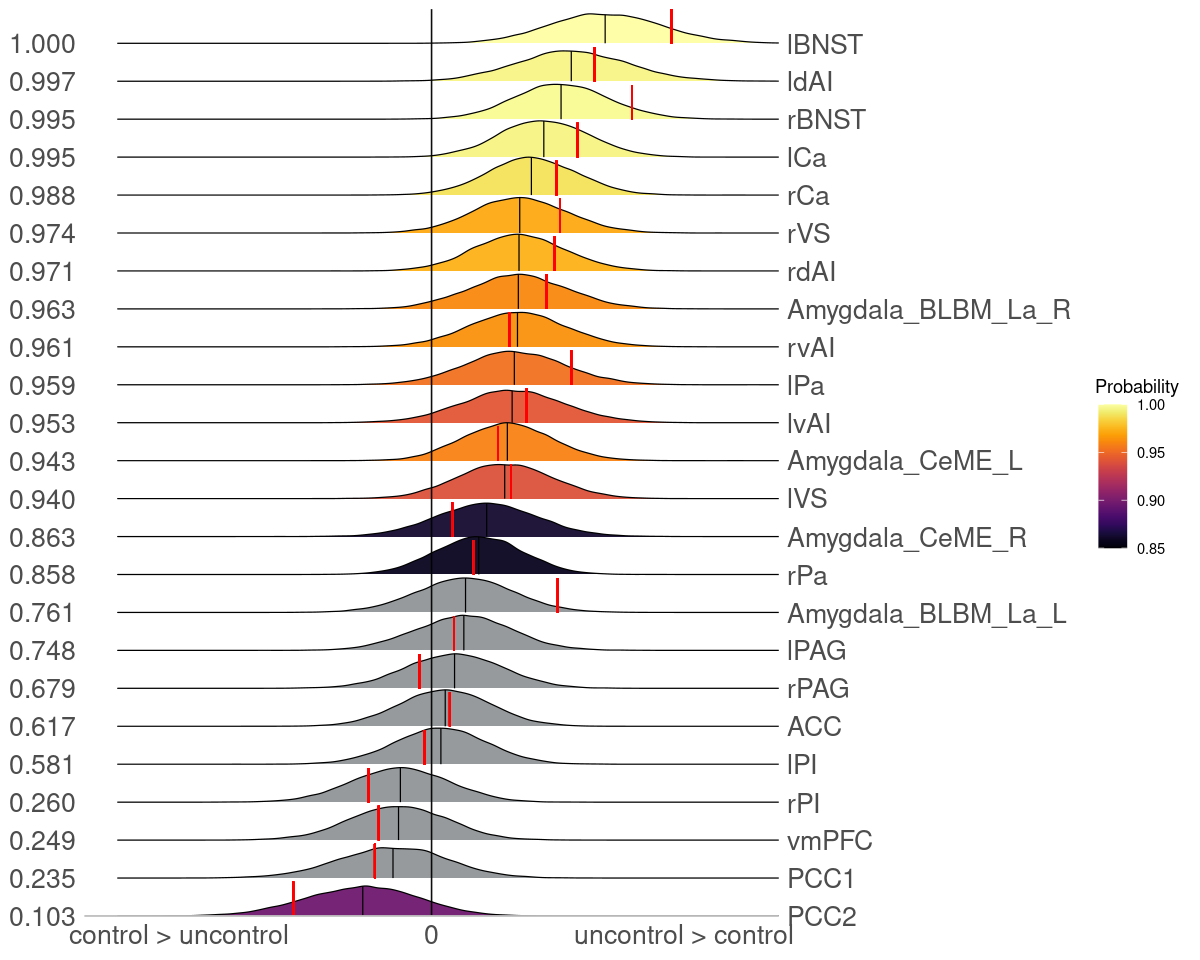

In [12]:
# for Intercept and quantitative variables
ii = 1
cat(sprintf('===== Summary of region effects for %s (RBA results) =====', EOIq[ii]), sep = '\n', append=TRUE)
ps0 <- psROI(aa, bb, EOIq[ii])
gg_brm <- sumROI(ps0, ns, nfigs)
#gg_brm$ROI <- factor(rownames(gg_brm))
cat(capture.output(gg_brm), sep = '\n', append=TRUE)

cat(sprintf('=================================================================================================================='),sep='\n')
cat(sprintf('===== Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =====', EOIq[ii]),sep = '\n', append=TRUE)
mm <- list()
GLM <- as.formula(paste('Y ~ ',mod))
if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM
for(kk in levels(dataTable$ROI)) mm[[kk]] = lm(GLM, data=dataTable[dataTable$ROI==kk,])
nn <- lapply(mm, summary)
ll <- lapply(nn, `[`, 'coefficients')
gg_glm <- sumGLM(ll, EOIq[ii], nR, nn[[ii]]$df, nfigs)
gg_glm = as.data.frame(gg_glm)
cat(capture.output(gg_glm),sep = '\n', append=TRUE)

cat(sprintf('======================================== Posteriors for %s ====================================================',EOIq[ii],sep='\n'))
plotPDP(ps0,gg_brm,gg_glm)

Red vertical lines: GLM

===== Summary of region effects for STATEmean (RBA results) =====
                     mean     SD     P+    2.5%      5%    50%    95%  97.5%
ACC                0.0043 0.0358 0.5705 -0.0716 -0.0562 0.0060 0.0601 0.0706
Amygdala_BLBM_La_L 0.0114 0.0336 0.6418 -0.0559 -0.0446 0.0120 0.0653 0.0754
Amygdala_BLBM_La_R 0.0088 0.0347 0.6178 -0.0629 -0.0500 0.0099 0.0639 0.0748
Amygdala_CeME_L    0.0229 0.0352 0.7460 -0.0436 -0.0331 0.0221 0.0818 0.0953
Amygdala_CeME_R    0.0115 0.0345 0.6446 -0.0595 -0.0463 0.0123 0.0662 0.0767
lBNST              0.0328 0.0381 0.8099 -0.0369 -0.0260 0.0306 0.0982 0.1131
lCa                0.0231 0.0333 0.7578 -0.0406 -0.0303 0.0226 0.0789 0.0903
ldAI               0.0156 0.0334 0.6865 -0.0510 -0.0396 0.0158 0.0696 0.0806
lPa                0.0167 0.0328 0.7014 -0.0479 -0.0377 0.0166 0.0699 0.0806
lPAG               0.0181 0.0332 0.7104 -0.0473 -0.0360 0.0180 0.0725 0.0836
lPI                0.0085 0.0342 0.6143 -0.0625 -0.0498 0.0092 0.0632 0.0734
lvAI      

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.00422



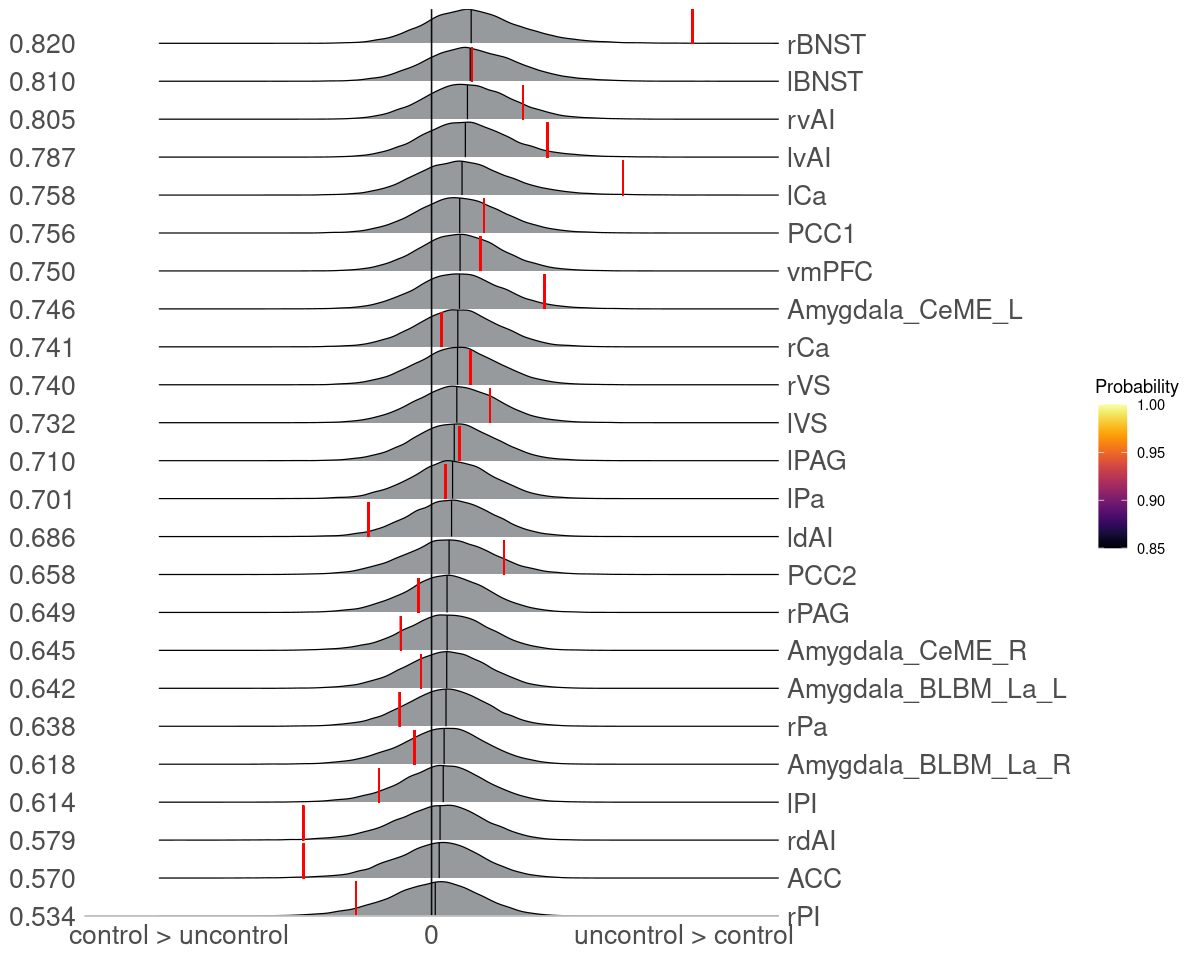

In [13]:
ii = 2
cat(sprintf('===== Summary of region effects for %s (RBA results) =====', EOIq[ii]), sep = '\n', append=TRUE)
ps0 <- psROI(aa, bb, EOIq[ii])
gg_brm <- sumROI(ps0, ns, nfigs)
#gg_brm$ROI <- factor(rownames(gg_brm))
cat(capture.output(gg_brm), sep = '\n', append=TRUE)

cat(sprintf('=================================================================================================================='),sep='\n')
cat(sprintf('===== Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =====', EOIq[ii]),sep = '\n', append=TRUE)
mm <- list()
GLM <- as.formula(paste('Y ~ ',mod))
if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM
for(kk in levels(dataTable$ROI)) mm[[kk]] = lm(GLM, data=dataTable[dataTable$ROI==kk,])
nn <- lapply(mm, summary)
ll <- lapply(nn, `[`, 'coefficients')
gg_glm <- sumGLM(ll, EOIq[ii], nR, nn[[ii]]$df, nfigs)
gg_glm = as.data.frame(gg_glm)
cat(capture.output(gg_glm),sep = '\n', append=TRUE)

cat(sprintf('======================================== Posteriors for %s ====================================================',EOIq[ii],sep='\n'))
plotPDP(ps0,gg_brm,gg_glm)

===== Summary of region effects for TRAITmean (RBA results) =====
                      mean     SD     P+    2.5%      5%     50%    95%  97.5%
ACC                -0.0070 0.0337 0.3978 -0.0698 -0.0600 -0.0086 0.0504 0.0638
Amygdala_BLBM_La_L -0.0157 0.0319 0.3044 -0.0786 -0.0679 -0.0159 0.0372 0.0480
Amygdala_BLBM_La_R -0.0095 0.0329 0.3712 -0.0721 -0.0618 -0.0103 0.0462 0.0580
Amygdala_CeME_L    -0.0182 0.0326 0.2836 -0.0837 -0.0722 -0.0178 0.0352 0.0455
Amygdala_CeME_R    -0.0108 0.0322 0.3603 -0.0728 -0.0629 -0.0115 0.0428 0.0546
lBNST              -0.0136 0.0337 0.3356 -0.0794 -0.0688 -0.0138 0.0428 0.0544
lCa                -0.0188 0.0320 0.2736 -0.0826 -0.0720 -0.0183 0.0333 0.0431
ldAI               -0.0152 0.0319 0.3079 -0.0774 -0.0675 -0.0152 0.0380 0.0484
lPa                -0.0135 0.0314 0.3262 -0.0746 -0.0647 -0.0139 0.0390 0.0494
lPAG               -0.0169 0.0317 0.2940 -0.0797 -0.0694 -0.0166 0.0352 0.0447
lPI                -0.0118 0.0323 0.3460 -0.0737 -0.0642 -0.0122 

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.00395



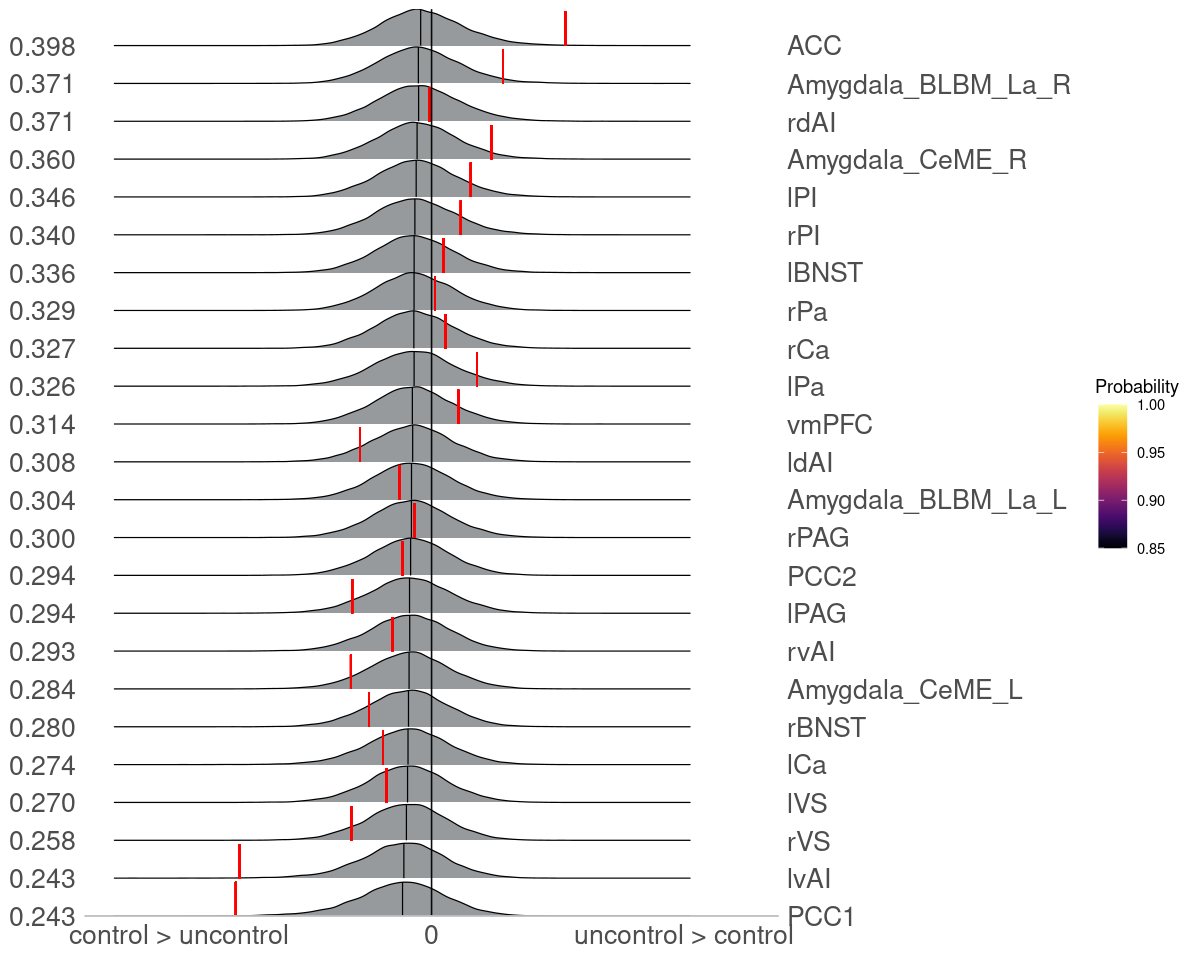

In [14]:
ii = 3
cat(sprintf('===== Summary of region effects for %s (RBA results) =====', EOIq[ii]), sep = '\n', append=TRUE)
ps0 <- psROI(aa, bb, EOIq[ii])
gg_brm <- sumROI(ps0, ns, nfigs)
#gg_brm$ROI <- factor(rownames(gg_brm))
cat(capture.output(gg_brm), sep = '\n', append=TRUE)

cat(sprintf('=================================================================================================================='),sep='\n')
cat(sprintf('===== Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =====', EOIq[ii]),sep = '\n', append=TRUE)
mm <- list()
GLM <- as.formula(paste('Y ~ ',mod))
if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM
for(kk in levels(dataTable$ROI)) mm[[kk]] = lm(GLM, data=dataTable[dataTable$ROI==kk,])
nn <- lapply(mm, summary)
ll <- lapply(nn, `[`, 'coefficients')
gg_glm <- sumGLM(ll, EOIq[ii], nR, nn[[ii]]$df, nfigs)
gg_glm = as.data.frame(gg_glm)
cat(capture.output(gg_glm),sep = '\n', append=TRUE)

cat(sprintf('======================================== Posteriors for %s ====================================================',EOIq[ii],sep='\n'))
plotPDP(ps0,gg_brm,gg_glm)

===== Summary of region effects for STATEdiff (RBA results) =====
                      mean     SD     P+    2.5%      5%     50%    95%  97.5%
ACC                 0.0025 0.0293 0.5406 -0.0564 -0.0467  0.0030 0.0496 0.0589
Amygdala_BLBM_La_L  0.0105 0.0300 0.6433 -0.0492 -0.0391  0.0104 0.0595 0.0695
Amygdala_BLBM_La_R  0.0333 0.0324 0.8538 -0.0259 -0.0169  0.0315 0.0890 0.1017
Amygdala_CeME_L     0.0146 0.0306 0.6870 -0.0457 -0.0361  0.0146 0.0646 0.0753
Amygdala_CeME_R     0.0226 0.0302 0.7766 -0.0353 -0.0262  0.0218 0.0731 0.0839
lBNST               0.0487 0.0361 0.9190 -0.0175 -0.0076  0.0467 0.1108 0.1235
lCa                 0.0265 0.0291 0.8223 -0.0289 -0.0206  0.0261 0.0748 0.0850
ldAI                0.0294 0.0298 0.8414 -0.0276 -0.0183  0.0290 0.0795 0.0904
lPa                 0.0249 0.0292 0.8079 -0.0309 -0.0216  0.0241 0.0739 0.0840
lPAG                0.0109 0.0291 0.6534 -0.0461 -0.0370  0.0114 0.0582 0.0680
lPI                 0.0044 0.0293 0.5678 -0.0544 -0.0444  0.0049 

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.00379



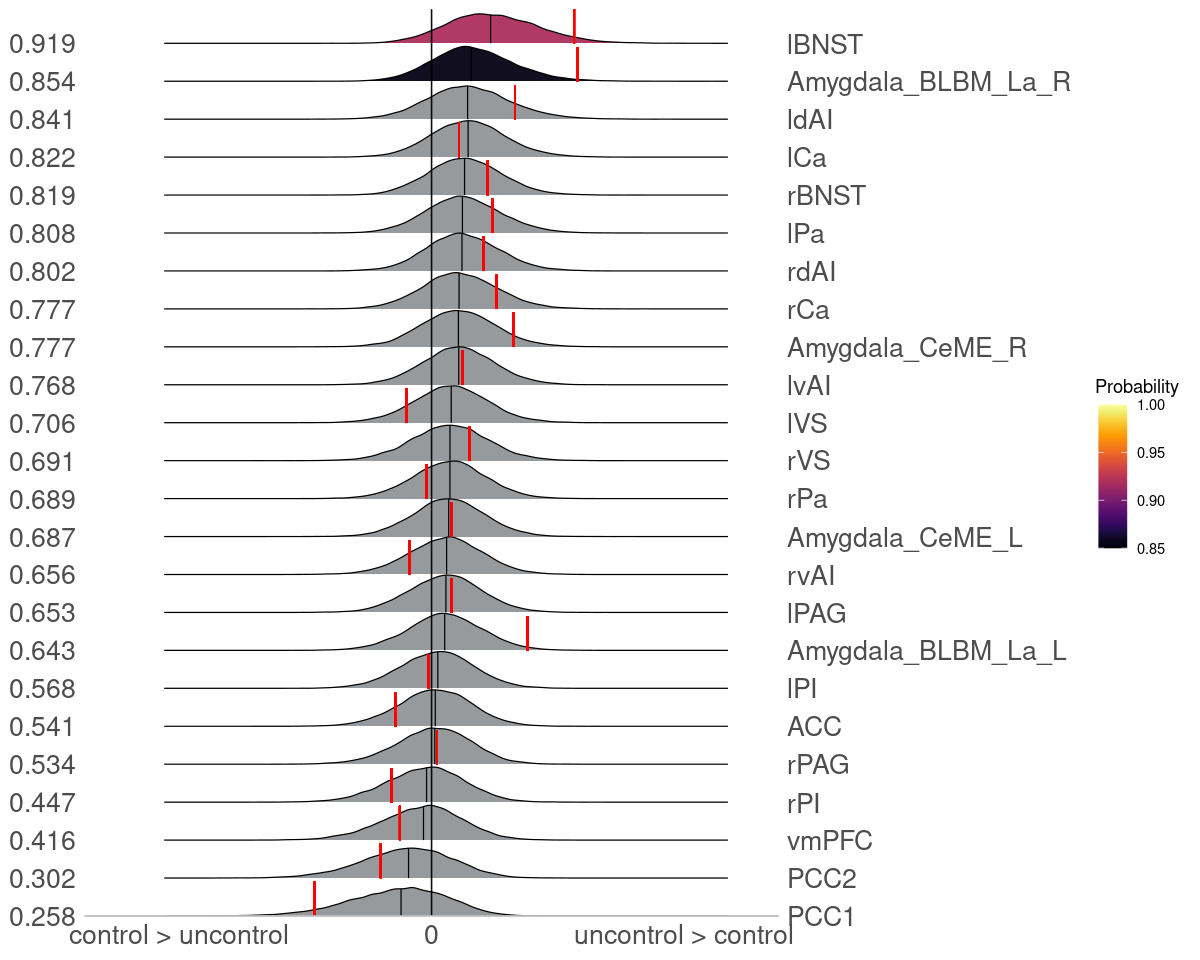

In [15]:
ii = 4
cat(sprintf('===== Summary of region effects for %s (RBA results) =====', EOIq[ii]), sep = '\n', append=TRUE)
ps0 <- psROI(aa, bb, EOIq[ii])
gg_brm <- sumROI(ps0, ns, nfigs)
#gg_brm$ROI <- factor(rownames(gg_brm))
cat(capture.output(gg_brm), sep = '\n', append=TRUE)

cat(sprintf('=================================================================================================================='),sep='\n')
cat(sprintf('===== Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =====', EOIq[ii]),sep = '\n', append=TRUE)
mm <- list()
GLM <- as.formula(paste('Y ~ ',mod))
if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM
for(kk in levels(dataTable$ROI)) mm[[kk]] = lm(GLM, data=dataTable[dataTable$ROI==kk,])
nn <- lapply(mm, summary)
ll <- lapply(nn, `[`, 'coefficients')
gg_glm <- sumGLM(ll, EOIq[ii], nR, nn[[ii]]$df, nfigs)
gg_glm = as.data.frame(gg_glm)
cat(capture.output(gg_glm),sep = '\n', append=TRUE)

cat(sprintf('======================================== Posteriors for %s ====================================================',EOIq[ii],sep='\n'))
plotPDP(ps0,gg_brm,gg_glm)

===== Summary of region effects for TRAITdiff (RBA results) =====
                      mean     SD     P+    2.5%      5%     50%    95%  97.5%
ACC                -0.0003 0.0261 0.4999 -0.0527 -0.0436  0.0000 0.0427 0.0504
Amygdala_BLBM_La_L  0.0047 0.0265 0.5662 -0.0462 -0.0378  0.0041 0.0489 0.0588
Amygdala_BLBM_La_R  0.0011 0.0261 0.5204 -0.0506 -0.0416  0.0013 0.0443 0.0530
Amygdala_CeME_L    -0.0010 0.0262 0.4918 -0.0537 -0.0439 -0.0005 0.0417 0.0499
Amygdala_CeME_R     0.0017 0.0260 0.5270 -0.0499 -0.0408  0.0017 0.0447 0.0538
lBNST               0.0062 0.0282 0.5809 -0.0474 -0.0387  0.0055 0.0534 0.0648
lCa                -0.0010 0.0260 0.4900 -0.0528 -0.0440 -0.0007 0.0410 0.0500
ldAI                0.0016 0.0262 0.5269 -0.0505 -0.0414  0.0017 0.0449 0.0534
lPa                 0.0025 0.0256 0.5374 -0.0473 -0.0390  0.0023 0.0451 0.0537
lPAG                0.0029 0.0259 0.5454 -0.0483 -0.0392  0.0028 0.0462 0.0551
lPI                 0.0039 0.0261 0.5551 -0.0471 -0.0382  0.0035 

Warning message in melt(data_trans, id = c("ROI", "X")):
“The melt generic in data.table has been passed a data.frame and will attempt to redirect to the relevant reshape2 method; please note that reshape2 is deprecated, and this redirection is now deprecated as well. To continue using melt methods from reshape2 while both libraries are attached, e.g. melt.list, you can prepend the namespace like reshape2::melt(data_trans). In the next version, this warning will become an error.”
Picking joint bandwidth of 0.00318



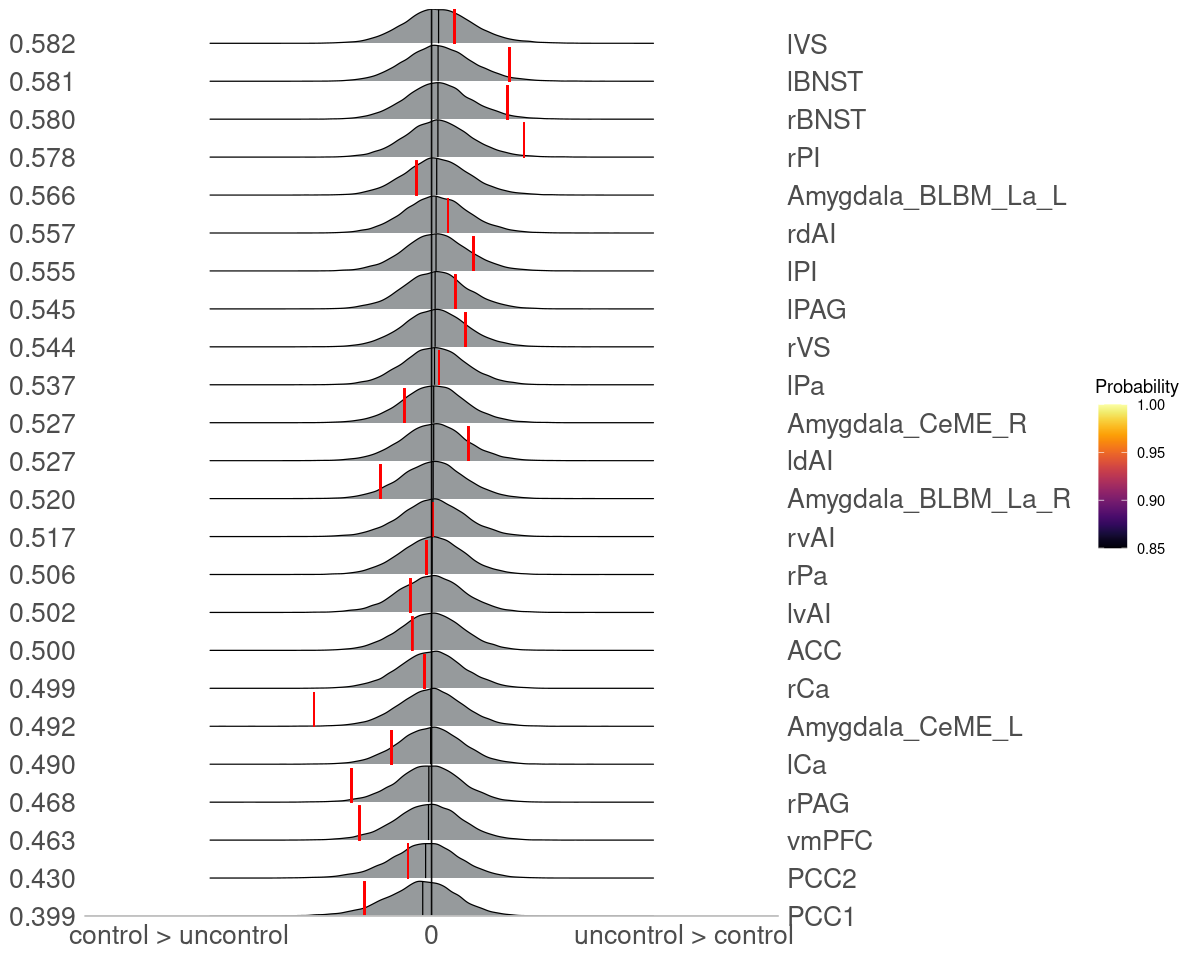

In [16]:
ii = 5
cat(sprintf('===== Summary of region effects for %s (RBA results) =====', EOIq[ii]), sep = '\n', append=TRUE)
ps0 <- psROI(aa, bb, EOIq[ii])
gg_brm <- sumROI(ps0, ns, nfigs)
#gg_brm$ROI <- factor(rownames(gg_brm))
cat(capture.output(gg_brm), sep = '\n', append=TRUE)

cat(sprintf('=================================================================================================================='),sep='\n')
cat(sprintf('===== Summary of region effects under GLM for %s (for reference only): no adjustment for multiplicity =====', EOIq[ii]),sep = '\n', append=TRUE)
mm <- list()
GLM <- as.formula(paste('Y ~ ',mod))
if(SCALE!=1) dataTable$Y <- (dataTable$Y)/SCALE  # scale back for GLM
for(kk in levels(dataTable$ROI)) mm[[kk]] = lm(GLM, data=dataTable[dataTable$ROI==kk,])
nn <- lapply(mm, summary)
ll <- lapply(nn, `[`, 'coefficients')
gg_glm <- sumGLM(ll, EOIq[ii], nR, nn[[ii]]$df, nfigs)
gg_glm = as.data.frame(gg_glm)
cat(capture.output(gg_glm),sep = '\n', append=TRUE)

cat(sprintf('======================================== Posteriors for %s ====================================================',EOIq[ii],sep='\n'))
plotPDP(ps0,gg_brm,gg_glm)

# **3. Posterior Predictive Check**

In [17]:
pp_plot = pp_check(fm,nsamples = 100)

Warning message:
“Removed 828 rows containing non-finite values (stat_density).”
Warning message:
“Removed 8 rows containing non-finite values (stat_density).”


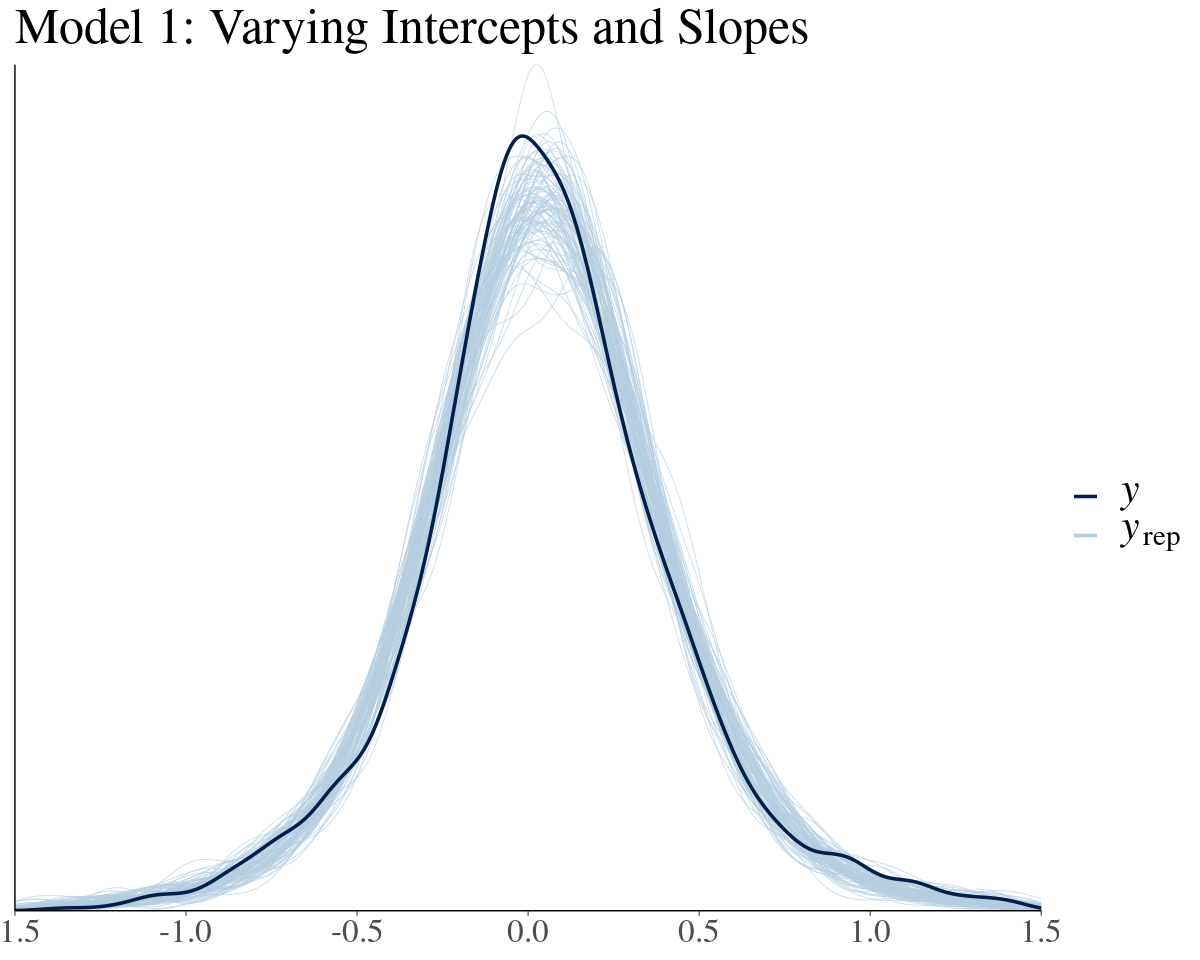

In [18]:
pp_plot + xlim(-1.5,1.5) + theme(text = element_text(size=25),legend.text=element_text(size=25)) + ggtitle("Model 1: Varying Intercepts and Slopes",)